# Error Analysis
#### Possible Error sources:

| Expert-labels | Model Prediction | Category |
|:-------------:|:----------------:|:----------------:|
| Yes | Yes but not concise | Dice coef. = [0~0.5] | 
| Yes | None | False Negative Instance (FN) |
| None | Yes | False Positive Instance (FP) |

#### Different Methods

* NerveDetector: Binary classifier (SimpleCNN) to predict presence of Nerve
* Prediction threshold > 0.5

| Method (# in Train / # in Valid) | Mean DSC | DSC=[0~0.6] | FP | FN | Total |
|:----:|:-----:|:----:|:----:|:------:|:------:|
| Only prediction threshold | 0.864 / 0.721 | 26 / 34 | 237 / 145 | 149 / 95 | 412 / 274 |
| Mask size > average training mask size | 0.877 / 0.732 | 13 / 21 | 174 / 128 | 163 / 110 | 350 / 259 |
| NerveDetector score >= 0.5 | 0.845 / 0.750 | 18 / 27 | 152 / 81 | 352 / 137 | 522 / 245 |
| Mask size & Detector score | 0.849 / 0.754 | 10 / 16 | 129 / 73 | 361 / 150 | 500 / 239 |

In [1]:
import pandas as pd
import numpy as np
from os.path import join, basename
from skimage.transform import resize
from skimage.io import imread, imsave

from sklearn.model_selection import train_test_split
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

import model_build, utils

Using TensorFlow backend.


In [2]:
def resize_img_pred(imgs_pred, t=0.5):
    final_img = np.zeros((imgs_pred.shape[0], 420, 580))

    for i, img in enumerate(imgs_pred):
        new_img = resize(img.astype('float32'), (420, 580), 
                         preserve_range=True, anti_aliasing=True, mode='reflect')
        new_img = new_img.reshape((420, 580))
        final_img[i, :, :] = new_img
    return (final_img > t).astype(np.uint8)


def dice(y_pred, y_true):
    """
    y_pred, y_true: (num, w, h)
    """
    result = []
    for seg, gt in zip(y_pred, y_true):
        if gt.sum() + seg.sum() == 0:
            d = 0.0
        else:
            d = distance.dice(np.ravel(seg.astype(bool)),
                              np.ravel(gt.astype(bool)))
        result += [1.0 - d]
    return np.array(result)


def get_miss_index(dc, imgs_masks, y_pred):
    fp = []
    fn = []
    total_miss = []
    for i, m in enumerate(imgs_masks[dc == 0]):
        if m.sum() == 0 and y_pred[dc == 0][i].sum() > 0:
            fp += [i]
        elif m.sum() > 0 and y_pred[dc == 0][i].sum() == 0:
            fn += [i]
        else:
            total_miss += [i]
    assert len(fp) + len(fn) + len(total_miss) == i + 1
    #print("FP: {}, FN: {}, MISS: {}".format(len(fp), len(fn), len(total_miss)))
    return fp, fn, total_miss

## Get model predictions

In [3]:
data_path = join('..', 'data')
imgs_train, imgs_masks = utils.load_train_data(data_path)

# Load network
net = model_build.load_model(join('..', 'models', 'Unet_v7'))
clf = model_build.load_model(join('..', 'models', 'SimpleCNN_v1'))
output_shape = net.layers[0].output_shape[1:-1]

# Preprocess and Split validation
imgs_train = utils.preprocess_x(imgs_train, new_shape=output_shape)
imgs_masks = (imgs_masks).astype(np.uint8)
val_size = int(5636 * 0.2)
x_train, x_val, y_train, y_val = train_test_split(imgs_train, imgs_masks, 
                                                  test_size=val_size, 
                                                  random_state=9487)
train_pred = net.predict(x_train, verbose=1)
val_pred = net.predict(x_val, verbose=1)
train_score = clf.predict(x_train, verbose=1)
val_score = clf.predict(x_val, verbose=1)

del net, clf

Training Stats: mu=99.3280258178711, sigma=56.435367584228516
1127/1127 [==============================] - 0s 198us/step


* imgs_train: 
    * Standardized training images (5635, 128, 128, 1), float64
* imgs_masks: 
    * Training masks (5635, 420, 580, 1), uint8 [0~255]
* pred: 
    * Thresholded prediction masks (uint8) [0~1]

In [10]:
train_preds = resize_img_pred(train_pred)
val_preds = resize_img_pred(val_pred)

In [6]:
# If prediction mask is too small, then probably there is no nerve
# Use average mask as threshold
average_mask_size = int((y_train // 255).mean(axis=0).sum())
train_preds[train_preds.sum(axis=(1,2)) < average_mask_size, :, :] = 0
val_preds[val_preds.sum(axis=(1,2)) < average_mask_size, :, :] = 0

In [11]:
# Use BinaryClassifier to give presence of Nerve a score
train_preds[train_score[:, 1] < 0.5, :, :] = 0
val_preds[val_score[:, 1] < 0.5, :, :] = 0

Train: Mean(Dice)=0.845
	Dice = [0~0.6]: 18

Validation: Mean(Dice)=0.750
	Dice = 0: 27

0.845 / 0.750 | 18 / 27 | 152 / 81 | 352 / 137 | 522 / 245 |


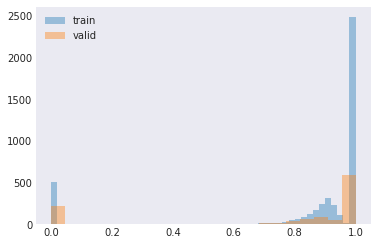

In [12]:
dc = dice(train_preds, y_train)
val_dc = dice(val_preds, y_val)

num_low_dice = dc[np.where(np.logical_and(dc > 0, dc < 0.6))].shape[0]
val_num_low_dice = val_dc[np.where(np.logical_and(val_dc > 0, val_dc < 0.6))].shape[0]

print("Train: Mean(Dice)={:.3f}".format(dc.mean()))
print("\tDice = [0~0.6]: {}\n".format(num_low_dice))
fp, fn, miss = get_miss_index(dc, y_train, train_preds)
t1 = len(fp) + len(fn) + num_low_dice

print("Validation: Mean(Dice)={:.3f}".format(val_dc.mean()))
print("\tDice = 0: {}\n".format(val_num_low_dice))
val_fp, val_fn, val_miss = get_miss_index(val_dc, y_val, val_preds)
t2 = len(val_fp) + len(val_fn) + val_num_low_dice

# Mean DSC | Dice=[0~0.5] | FP | FN | Total |
print("{d1:.3f} / {d2:.3f} | {ld1:d} / {ld2:d} | {fp1:d} / {fp2:d} | {fn1:d} / {fn2:d} | \
{t1:d} / {t2:d} |".format(d1=dc.mean(), d2=val_dc.mean(), 
                                 ld1=num_low_dice, ld2=val_num_low_dice, 
                                 fp1=len(fp), fp2=len(val_fp), 
                                  fn1=len(fn), fn2=len(val_fn), t1=t1, t2=t2))

## Plot dice coefficient distribution
plt.style.use('seaborn-dark')
sns.distplot(dc, kde=False, label='train')
sns.distplot(val_dc, kde=False, label='valid')

plt.legend()
plt.show()
plt.close()

-------
## Investigate FP & FN
* Do they occur because of expert-label conflict?
    * Similar images with different masks


* [Go to top](#Error-Analysis)

In [51]:
imgs_train, imgs_masks = utils.load_train_data(data_path)
imgs_masks = (imgs_masks).astype(np.uint8)
val_size = int(5636 * 0.2)
x_train, x_val, y_train, y_val = train_test_split(imgs_train, imgs_masks, 
                                                  test_size=val_size, 
                                                  random_state=9487)

In [212]:
fp = x_val[val_dc == 0][val_fp]
fp_mask = y_val[val_dc == 0][val_fp]
fp_pred = val_preds[val_dc == 0][val_fp]

fn = x_val[val_dc == 0][val_fn]
fn_mask = y_val[val_dc == 0][val_fn]
fn_pred = val_preds[val_dc == 0][val_fn]

False positive mask size is smaller compared with all prediction mask

Ks: 0.1648207519673564, p-value: 0.06436760315999047
t: -2.725459491746896, p-value: 0.007499643941583855


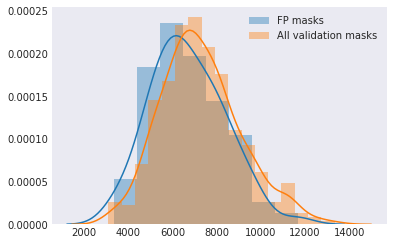

In [213]:
from scipy.stats import ks_2samp, ttest_ind

fp_px_size = []
val_px_size = []
for pred in fp_pred:
    fp_px_size += [pred.sum()]
    
for mask in val_preds:
    if mask.sum() == 0: continue
    val_px_size += [mask.sum()]

fp_px_size = np.array(fp_px_size)
val_px_size = np.array(val_px_size)

ks, pval = ks_2samp(fp_px_size, val_px_size)
tt, tpval = ttest_ind(fp_px_size, val_px_size, 
                      equal_var=(fp_px_size.var() == val_px_size.var()))
print("Ks: {}, p-value: {}".format(ks, pval))
print("t: {}, p-value: {}".format(tt, tpval))
sns.distplot(fp_px_size, label='FP masks')
sns.distplot(val_px_size, label='All validation masks')
plt.legend()
plt.show()
plt.close()

In [180]:
from scipy.spatial.distance import cdist
def sumdist(x, y):
    assert x.max() == y.max()
    return np.abs(x - y).sum()

# Subset training images that has masks
y_have_masks = y_train[y_train.sum(axis=(1,2)) > 0] // 255
x_have_masks = x_train[y_train.sum(axis=(1,2)) > 0] // 255

print(x_train.shape, x_have_masks.shape)

dmat = cdist(fp.reshape((fp.shape[0], -1))//255,
             x_have_masks.reshape((1870, -1)),
             metric=sumdist)

(4508, 420, 580) (1870, 420, 580)


True


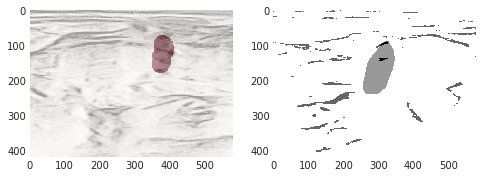

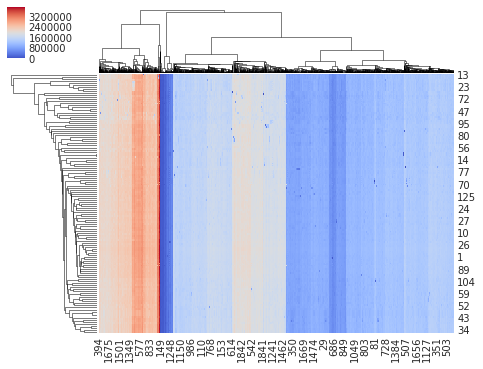

In [181]:
t = 23000000
rows, cols = np.where(dmat < t)
for r, c in zip(rows, cols):
    
    fig, ax = plt.subplots(1, 2, figsize=(8,6))
    print(sumdist(fp[r].flatten()//255, x_have_masks[c].flatten()) < t)
    ax[0].imshow(fp[r])
    ax[0].imshow(fp_mask[r], alpha=0.4)
    ax[0].imshow(fp_pred[r], alpha=0.4, cmap='Reds')
    
    ax[1].imshow(x_have_masks[c])
    ax[1].imshow(y_have_masks[c], alpha=0.4)
    break
    
sns.clustermap(dmat, cmap='coolwarm', figsize=(8,6))
plt.show()
plt.close()

##### Random 25 cases of False Positive

In [214]:
import random
random.seed(9487)

tmp = random.sample(list(zip(fp, fp_mask, fp_pred)), 25)
rand_fp_x, rand_fp_mask, rand_fp_pred = list(zip(*tmp))
#rand_fp_mask = random.sample(list(fp_mask), 25)
#rand_fp_pred = random.sample(list(fp_pred), 25)

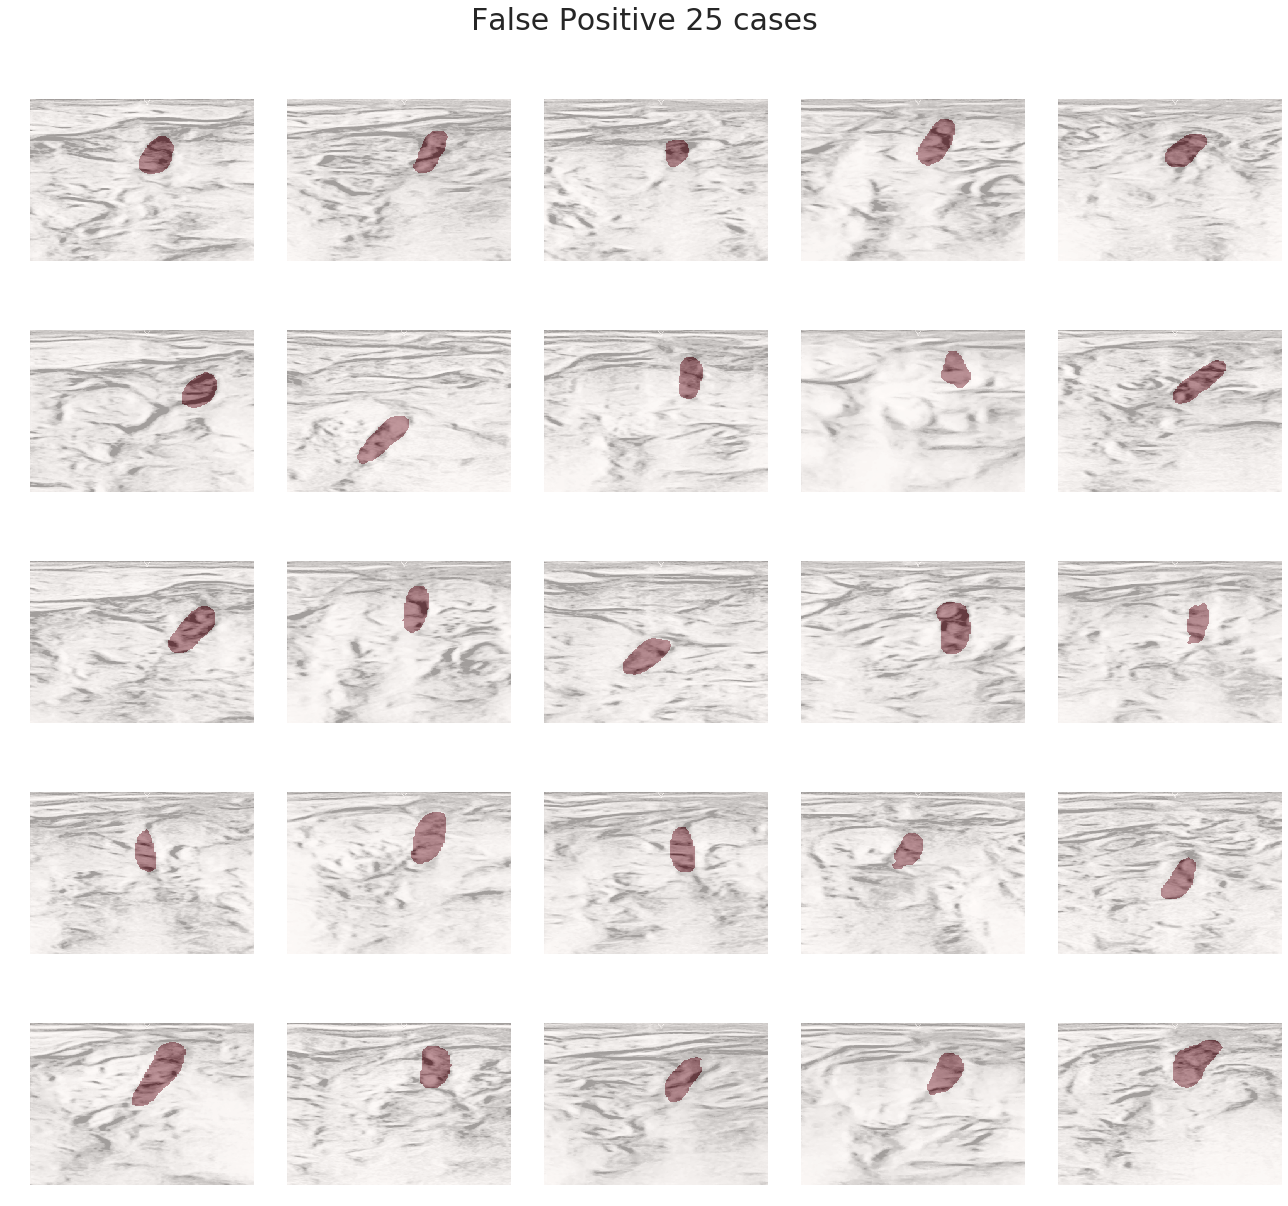

In [215]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))
for i in range(25):
    row = i // 5
    col = i % 5
    
    ax[row][col].axis('off')
    ax[row][col].imshow(rand_fp_x[i])
    ax[row][col].imshow(rand_fp_mask[i], alpha=0.4)
    ax[row][col].imshow(rand_fp_pred[i], alpha=0.4, cmap='Reds')

plt.suptitle("False Positive 25 cases", fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

----
## Visualize Low dice coef. instances
* [Go to top](#Error-Analysis)

In [204]:
imgs_train, imgs_masks = utils.load_train_data(data_path)
imgs_masks = (imgs_masks).astype(np.uint8)
val_size = int(5636 * 0.2)
x_train, x_val, y_train, y_val = train_test_split(imgs_train, imgs_masks, 
                                                  test_size=val_size, 
                                                  random_state=9487)

In [220]:
low_dice_idx = np.where(np.logical_and(dc > 0, dc < 0.5))[0]
low_dice_idx = low_dice_idx[dc[low_dice_idx].argsort()[::-1]]
len(low_dice_idx)

5

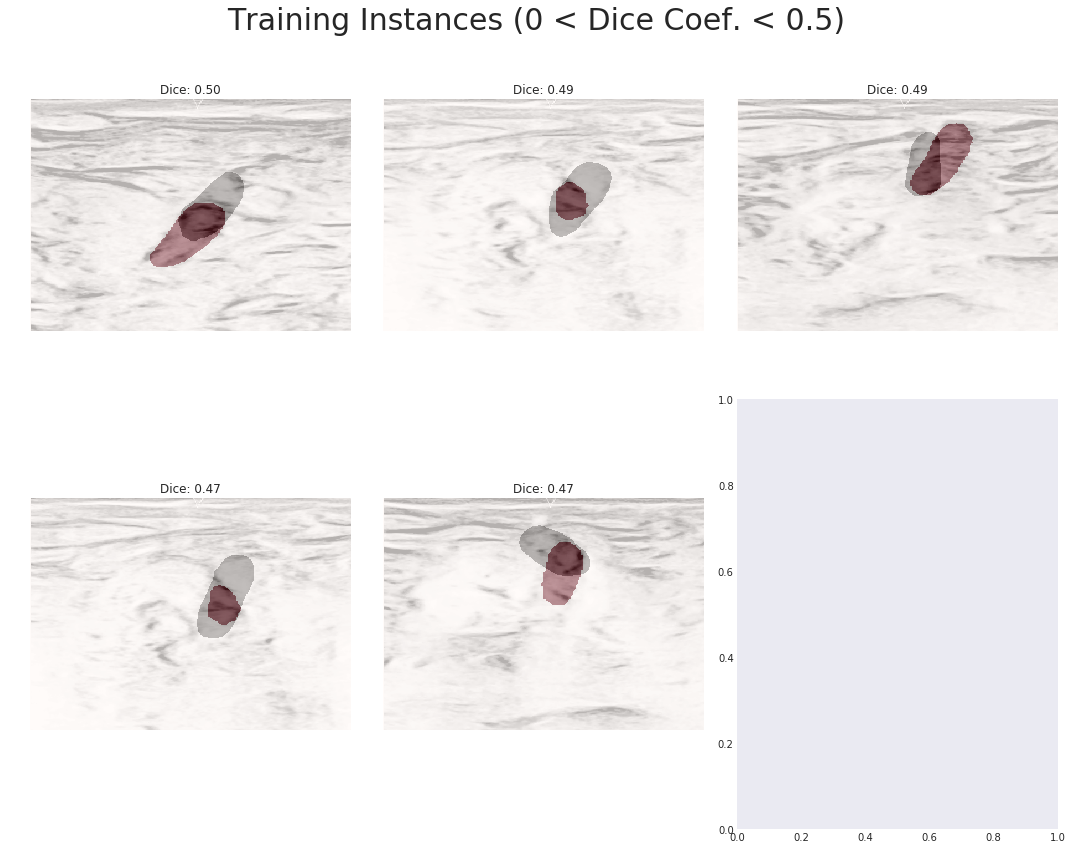

In [221]:
fig, ax = plt.subplots(2, 3, figsize=(15,12))

for index, (pred, mask) in enumerate(zip(train_preds[low_dice_idx], \
                                         y_train[low_dice_idx])):
    row = index // 3
    col = index % 3
    pred = pred * 255
    
    ax[row][col].imshow(x_train[low_dice_idx][index], alpha=0.8)
    ax[row][col].imshow(mask, alpha=0.4)
    ax[row][col].imshow(pred, alpha=0.4, cmap='Reds')
    ax[row][col].axis('off')
    ax[row][col].set_title("Dice: {:.2f}".format(dc[low_dice_idx[index]]))

plt.tight_layout()
plt.suptitle("Training Instances (0 < Dice Coef. < 0.5)", fontsize=30)
plt.savefig("Training_low_dice_CNN+Sizefiltered.png", dpi=600)

#### Valid

In [209]:
low_dice_idx = np.where(np.logical_and(val_dc > 0, val_dc < 0.5))[0]
low_dice_idx = low_dice_idx[val_dc[low_dice_idx].argsort()[::-1]]
len(low_dice_idx)

6

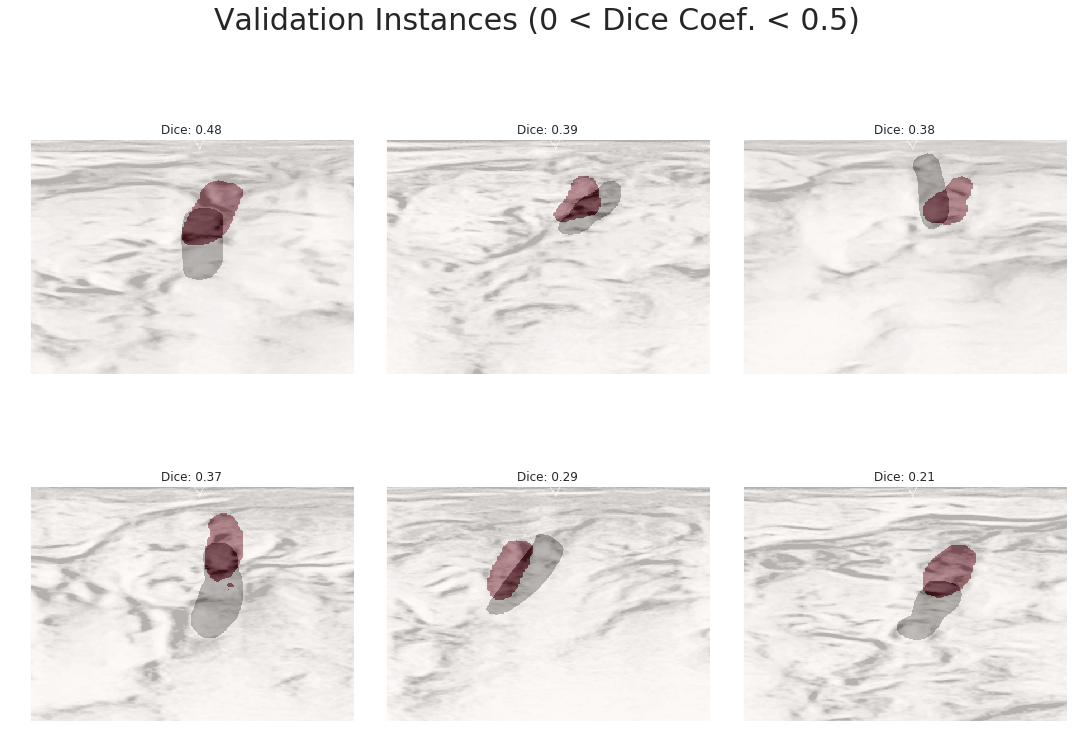

In [210]:
fig, ax = plt.subplots(2, 3, figsize=(15,12))

for index, (pred, mask) in enumerate(zip(val_preds[low_dice_idx], \
                                         y_val[low_dice_idx])):
    row = index // 3
    col = index % 3
    pred = pred * 255
    
    ax[row][col].imshow(x_val[low_dice_idx][index], alpha=0.8)
    ax[row][col].imshow(mask, alpha=0.4)
    ax[row][col].imshow(pred, alpha=0.4, cmap='Reds')
    ax[row][col].axis('off')
    ax[row][col].set_title("Dice: {:.2f}".format(val_dc[low_dice_idx[index]]))

plt.suptitle("Validation Instances (0 < Dice Coef. < 0.5)", fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Valid_low_dice_CNN+Sizefiltered.png", dpi=600)

## Clear Image Labels
* [Ref](https://github.com/julienr/kaggle_uns/blob/master/13_clean/0_filter_incoherent_images.ipynb)

In [9]:
data_path = join('..', 'data')
imgs_train, imgs_masks = utils.load_train_data(data_path)

In [10]:
import skimage.util

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

In [35]:
hists = np.array(list(map(compute_img_hist, imgs_train)))
hists.shape

(5635, 189)

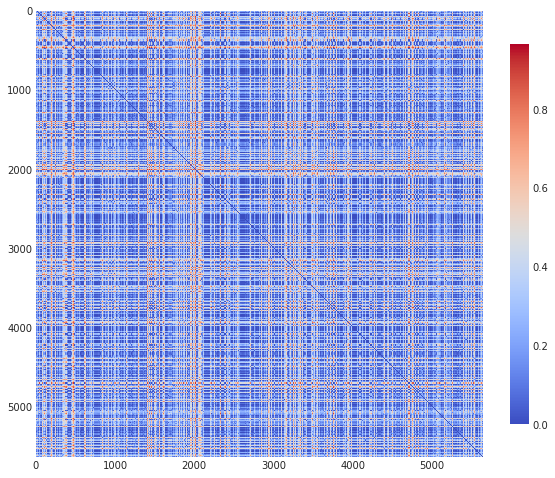

In [28]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

plt.style.use('seaborn-dark')
plt.figure(figsize=(10, 10))
plt.imshow(D, interpolation='nearest', cmap='coolwarm')
plt.colorbar(shrink=0.7)

In [39]:
import os
import glob

In [94]:
def dice_coefficient(Y_pred, Y):
    """
    This works for one image
    http://stackoverflow.com/a/31275008/116067
    """
    denom = (np.sum(Y_pred == 1) + np.sum(Y == 1))
    if denom == 0:
        # By definition, see https://www.kaggle.com/c/ultrasound-nerve-segmentation/details/evaluation
        return 1
    else:
        return 2 * np.sum(Y[Y_pred == 1]) / float(denom)


def load_and_preprocess(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = imread(join('..', 'data', 'train', 'images', img_fname))
    assert img is not None
    mask = imread(join('..', 'data', 'masks', 'images', mask_fname))
    assert mask is not None

    mask = (mask > 128).astype(np.float32)
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask


def load_patient(pid):
    fnames = [basename(fname) for fname in 
              glob.glob("../data/train/images/" + "/%d_*.tif" % pid) if 'mask' not in fname]
    imgs, masks = zip(*map(load_and_preprocess, fnames))
    return np.array(imgs), np.array(masks), fnames

In [97]:
OUTDIR = '../data/data_clean'

if not os.path.exists(join(OUTDIR, 'x_train', 'images')):
    os.makedirs(join(OUTDIR, 'x_train', 'images'))
if not os.path.exists(join(OUTDIR, 'y_train', 'images')):
    os.makedirs(join(OUTDIR, 'y_train', 'images'))
    

def filter_images_for_patient(pid):
    imgs, masks, fnames = load_patient(pid)
    hists = np.array(list(map(compute_img_hist, imgs)))
    D = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    
    # Used 0.005 to train at 0.67
    close_pairs = D + np.eye(D.shape[0]) < 0.008
    
    close_ij = np.transpose(np.nonzero(close_pairs))
    
    incoherent_ij = [(i, j) for i, j in close_ij if 
                     dice_coefficient(masks[i], masks[j]) < 0.2]
    incoherent_ij = np.array(incoherent_ij)
     
    valids = np.ones(len(imgs), dtype=np.bool)
    for i, j in incoherent_ij:
        if np.sum(masks[i]) == 0:
            valids[i] = False
        if np.sum(masks[j]) == 0:
            valids[i] = False

    for i in np.flatnonzero(valids):
        imgname = os.path.splitext(fnames[i])[0] + ".tif"
        mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
        img = skimage.img_as_uint(imgs[i])
        imsave(join(OUTDIR, 'x_train', 'images', imgname), img, plugin='pil')
        mask = skimage.img_as_uint(masks[i])
        imsave(join(OUTDIR, 'y_train', 'images', mask_fname), mask, plugin='pil')
    print('Discarded ', np.count_nonzero(~valids), " images for patient %d" % pid)

In [98]:
import warnings
warnings.filterwarnings("ignore")

for pid in range(1, 48):
    filter_images_for_patient(pid)

Discarded  67  images for patient 1
Discarded  8  images for patient 2
Discarded  16  images for patient 3
Discarded  30  images for patient 4
Discarded  50  images for patient 5
Discarded  43  images for patient 6
Discarded  41  images for patient 7
Discarded  41  images for patient 8
Discarded  17  images for patient 9
Discarded  49  images for patient 10
Discarded  35  images for patient 11
Discarded  27  images for patient 12
Discarded  33  images for patient 13
Discarded  51  images for patient 14
Discarded  36  images for patient 15
Discarded  15  images for patient 16
Discarded  31  images for patient 17
Discarded  31  images for patient 18
Discarded  32  images for patient 19
Discarded  16  images for patient 20
Discarded  54  images for patient 21
Discarded  30  images for patient 22
Discarded  36  images for patient 23
Discarded  13  images for patient 24
Discarded  25  images for patient 25
Discarded  29  images for patient 26
Discarded  26  images for patient 27
Discarded  